In [1]:
import os
import numpy as np
import pandas as pd
import sys
import pickle
from tqdm.notebook import tqdm, trange
import rdkit 
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import mols2grid
import subprocess

In [2]:
# define paths
notebook_path = os.path.realpath(os.getcwd())
root_dir_path = os.path.dirname(notebook_path)
code_path = root_dir_path + os.sep + "VirtuousMultiTaste" + os.sep
src_path = code_path + os.sep + "src" + os.sep
data_path = root_dir_path + os.sep + "data" + os.sep
test_path = os.path.join(notebook_path, 'test')

In [3]:
# import Virtuous Library
sys.path.append(code_path)
import Virtuous

[13:07:48] Initializing Normalizer


In [4]:
Virtuous.__version__

'1.11'

## Load DBs

In [5]:
# path to the file in the Dropbox folder 
fourTaste_train_file = data_path +  "training_dataset_fourtaste_problem.csv"
fourTaste_test_file  = data_path +  "testing_dataset_fourtaste_problem.csv"

In [6]:
DB_train = pd.read_csv(fourTaste_train_file, sep="\t", low_memory=False)
DB_test  = pd.read_csv(fourTaste_test_file,  sep="\t", low_memory=False)
DB = pd.concat([DB_train, DB_test], axis=0)

In [7]:
DB

,Unnamed: 0,Taste,Std_SMILES,Parent_SMILES,SEQUENCE
0,0,Umami,C[C@H](NC(=O)[C@@H]1CCCN1)C(=O)N[C@@H](CCC(N)=...,C[C@H](NC(=O)[C@@H]1CCCN1)C(=O)N[C@@H](CCC(N)=...,PAQ
1,1,Bitter,OC/C=C/c1ccccc1,OC/C=C/c1ccccc1,NaN
2,2,Tasteless,COc1ccc(C(=O)c2ccccc2C(=O)O)cc1OC,COc1ccc(C(=O)c2ccccc2C(=O)O)cc1OC,NaN
3,3,Sweet,CC(C)CC1OC(CC(C)C)OC(CC(C)C)O1,CC(C)CC1OC(CC(C)C)OC(CC(C)C)O1,NaN
4,4,Sweet,C=CC(C)(CCC=C(C)C)OC(=O)/C=C/c1ccccc1,C=CC(C)(CCC=C(C)C)OC(=O)/C=C/c1ccccc1,NaN
...,...,...,...,...,...
3405,3405,Sweet,O=C1NS(=O)(=O)c2cscc12,O=C1NS(=O)(=O)c2cscc12,NaN
3406,3406,Sweet,COCC(NC(=Nc1ccc(C#N)cc1)NCC(=O)O)c1ccccc1,COCC(NC(=Nc1ccc(C#N)cc1)NCC(=O)O)c1ccccc1,NaN
3407,3407,Sweet,CC(C)(C)OC(=O)CCNC(=O)C(N)CC(=O)O,CC(C)(C)OC(=O)CCNC(=O)C(N)CC(=O)O,NaN
3408,3408,Sweet,CC(C)=CCC/C(C)=C/COC(=O)Cc1ccccc1,CC(C)=CCC/C(C)=C/COC(=O)Cc1ccccc1,NaN


In [8]:
DB.Parent_SMILES.to_csv(test_path + os.sep + "temp.txt", index=False, header=False)

In [63]:
#subprocess.call(['python', code_path + os.sep + 'VirtuousMultiTaste.py', '-f', test_path + os.sep + 'temp.txt', '-d', 'test/temp'])

/Users/lorenzo/opt/anaconda3/envs/VIRTUOUS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lorenzo/opt/anaconda3/envs/VIRTUOUS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lorenzo/opt/anaconda3/envs/VIRTUOUS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lorenzo/opt/anaconda3/envs/VIRTUOUS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lorenzo/opt/anaconda3/envs/VIRTUOUS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.redu

0

In [9]:
#retrive predicted values
DB["Taste_prediction"] = pd.read_csv(test_path + os.sep + "temp/result_dominant_label.txt", sep="\t", header=None)[0]
# replace 'Tasteless with 'Other' to be consistent with the original dataset
DB["Taste"] = DB["Taste"].replace("Tasteless", "Other")
DB

,Unnamed: 0,Taste,Std_SMILES,Parent_SMILES,SEQUENCE,Taste_prediction
0,0,Umami,C[C@H](NC(=O)[C@@H]1CCCN1)C(=O)N[C@@H](CCC(N)=...,C[C@H](NC(=O)[C@@H]1CCCN1)C(=O)N[C@@H](CCC(N)=...,PAQ,Umami
1,1,Bitter,OC/C=C/c1ccccc1,OC/C=C/c1ccccc1,NaN,Bitter
2,2,Other,COc1ccc(C(=O)c2ccccc2C(=O)O)cc1OC,COc1ccc(C(=O)c2ccccc2C(=O)O)cc1OC,NaN,Other
3,3,Sweet,CC(C)CC1OC(CC(C)C)OC(CC(C)C)O1,CC(C)CC1OC(CC(C)C)OC(CC(C)C)O1,NaN,Sweet
4,4,Sweet,C=CC(C)(CCC=C(C)C)OC(=O)/C=C/c1ccccc1,C=CC(C)(CCC=C(C)C)OC(=O)/C=C/c1ccccc1,NaN,Sweet
...,...,...,...,...,...,...
3405,3405,Sweet,O=C1NS(=O)(=O)c2cscc12,O=C1NS(=O)(=O)c2cscc12,NaN,Other
3406,3406,Sweet,COCC(NC(=Nc1ccc(C#N)cc1)NCC(=O)O)c1ccccc1,COCC(NC(=Nc1ccc(C#N)cc1)NCC(=O)O)c1ccccc1,NaN,Sweet
3407,3407,Sweet,CC(C)(C)OC(=O)CCNC(=O)C(N)CC(=O)O,CC(C)(C)OC(=O)CCNC(=O)C(N)CC(=O)O,NaN,Bitter
3408,3408,Sweet,CC(C)=CCC/C(C)=C/COC(=O)Cc1ccccc1,CC(C)=CCC/C(C)=C/COC(=O)Cc1ccccc1,NaN,Other


In [10]:
# retrieve performance metrics
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score, auc   

accuracy_score = accuracy_score(DB["Taste"], DB["Taste_prediction"])
accuracy_score

0.5223659105363578

In [11]:
print ("Number of all compounds in the dataset: %d" %DB.shape[0])
print ("\nNumber of compounds in the training set: %d" %DB_train.shape[0])
print ("Number of compounds in the testing  set: %d" %DB_test.shape[0])
print ("\nNumber of SWEET compounds in the training set: %d" %(DB_train["Taste"]=="Sweet").sum())
print ("Number of SWEET compounds in the testing  set: %d" %(DB_test["Taste"]=="Sweet").sum())
print ("\nNumber of BITTER compounds in the training set: %d" %(DB_train["Taste"]=="Bitter").sum())
print ("Number of BITTER compounds in the testing  set: %d" %(DB_test["Taste"]=="Bitter").sum())
print ("\nNumber of UMAMI compounds in the training set: %d" %(DB_train["Taste"]=="Umami").sum())
print ("Number of UMAMI compounds in the testing  set: %d" %(DB_test["Taste"]=="Umami").sum())
print ("\nNumber of OTHER compounds in the training set: %d" %(DB_train["Taste"]=="Tasteless").sum())
print ("Number of OTHER compounds in the testing  set: %d" %(DB_test["Taste"]=="Tasteless").sum())

Number of all compounds in the dataset: 4717

Number of compounds in the training set: 1307
Number of compounds in the testing  set: 3410

Number of SWEET compounds in the training set: 360
Number of SWEET compounds in the testing  set: 1544

Number of BITTER compounds in the training set: 360
Number of BITTER compounds in the testing  set: 1577

Number of UMAMI compounds in the training set: 227
Number of UMAMI compounds in the testing  set: 0

Number of OTHER compounds in the training set: 360
Number of OTHER compounds in the testing  set: 289


In [12]:
DB_train = DB_train.reset_index()
DB_test  = DB_test.reset_index()
DB = DB.reset_index()

## Define the Applicability Domain of Umami DB

In [13]:
AD_train_file = src_path + os.sep + "fourtaste_AD_train.pkl"
AD_file = src_path + os.sep + "fourtaste_AD.pkl"

AD_train = Virtuous.DefineAD(DB_train, smile_field="Parent_SMILES", output_filename=AD_train_file)
AD = Virtuous.DefineAD(DB, smile_field="Parent_SMILES", output_filename=AD_file)

#### Define number of neighbors

In [14]:
vicini = 5
metric = "tanimoto"

## Retrieve threshold for the AD definition

#### Training-Training comparison

In [16]:
train_scores = []

# cycle over the Umami DB
for i in tqdm(range(len(DB_train))):
        
    # calculate the average similarity score of all compounds with the umami AD
    test, score, sim_smiles = Virtuous.TestAD(DB_train.Parent_SMILES[i], filename=AD_train_file, verbose = False, neighbors = vicini, metric=metric) 
    train_scores.append(score)

  0%|          | 0/1307 [00:00<?, ?it/s]

#### Training-Testing comparison

In [17]:
test_scores = []

# cycle over the Umami DB
for i in tqdm(range(len(DB_test))):
        
    # calculate §average similarity score of all umami compounds with the umami AD
    test, score, sim_smiles = Virtuous.TestAD(DB_test.Parent_SMILES[i], filename=AD_train_file, verbose = False, neighbors = vicini, metric = metric) 
    test_scores.append(score)

  0%|          | 0/3410 [00:00<?, ?it/s]

### Create a dataframe to analyse the similarity and run the prediction

In [18]:
test_AD = pd.DataFrame()
test_AD["Parent_SMILES"] = DB_test.Parent_SMILES
test_AD["Taste"] = DB_test.Taste
test_AD["AD_score"] = test_scores

# divide the test set into quartiles according to the AD score
test_AD = test_AD.sort_values(by="AD_score", ascending=False)
test_AD["AD_quartile"] = pd.qcut(test_AD["AD_score"], 10, labels=False)
test_AD["AD_quartile"] = test_AD["AD_quartile"].astype("int")
test_AD.reset_index(inplace=True)
test_AD

,index,Parent_SMILES,Taste,AD_score,AD_quartile
0,2456,CCC(C)C(=O)OC(C)C1(O)CCC2(O)C3CCC4CC(OC5CC(O)C...,Sweet,0.924050,9
1,1020,CCC(C)C(=O)OC(C)C1(O)CCC2(O)C3CCC4CC(OC5CC(O)C...,Sweet,0.889688,9
2,174,CCC(C)C(=O)OC(C)C1(O)CCC2(O)C3CCC4CC(OC5CC(O)C...,Sweet,0.889688,9
3,2889,CCC(C)C(=O)OC(C)C1(O)CCC2(O)C3CCC4CC(OC5CC(O)C...,Sweet,0.870749,9
4,1890,CCC(C)C(=O)OC(C)C1(O)CCC2(O)C3CCC4CC(OC5CC(O)C...,Sweet,0.870749,9
...,...,...,...,...,...
3405,2651,N#N,Tasteless,0.053352,0
3406,2596,S,Tasteless,0.043956,0
3407,954,[Ar],Tasteless,0.041712,0
3408,1845,Cl.N,Tasteless,0.036840,0


In [36]:
train_AD = pd.DataFrame()
train_AD["Parent_SMILES"] = DB_train.Parent_SMILES
train_AD["Taste"] = DB_train.Taste
train_AD["AD_score"] = train_scores

# divide the train set into quartiles according to the AD score
train_AD = train_AD.sort_values(by="AD_score", ascending=False)
train_AD["AD_quartile"] = pd.qcut(train_AD["AD_score"], 10, labels=False)
train_AD["AD_quartile"] = train_AD["AD_quartile"].astype("int")
train_AD.reset_index(inplace=True)
train_AD


,index,Parent_SMILES,Taste,AD_score,AD_quartile
0,199,NC(=O)CC[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H]...,Umami,0.933333,9
1,1232,NC(=O)CC[C@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H]...,Umami,0.933333,9
2,359,NC(=O)CC[C@H](NC(=O)[C@@H](N)CCC(=O)O)C(=O)N[C...,Umami,0.933333,9
3,271,CCC(C)C(=O)OC(C)C1(O)CCC2(O)C3CCC4CC(OC5CC(OC)...,Tasteless,0.927876,9
4,717,CCC(C)C(=O)OC(C)C1(O)CCC2(O)C3CCC4CC(OC5CC(O)C...,Tasteless,0.924050,9
...,...,...,...,...,...
1302,953,[Ca+2].[OH-].[OH-],Bitter,0.258317,0
1303,435,FS(F)(F)(F)(F)F,Tasteless,0.252697,0
1304,129,[Rn],Tasteless,0.238590,0
1305,975,[C-]#[O+],Tasteless,0.232051,0


In [37]:
# export Parent SMILES into a txt
test_AD.Parent_SMILES.to_csv(test_path + os.sep + "test_AD_SMILES.txt", sep="\t", index=False, header=False)
train_AD.Parent_SMILES.to_csv(test_path + os.sep + "train_AD_SMILES.txt", sep="\t", index=False, header=False)

In [38]:
# run the prediction code (un commment to run)
#subprocess.call(['python', code_path + os.sep + 'VirtuousMultiTaste.py', '-f', test_path + os.sep + 'test_AD_SMILES.txt', '-d', 'test/test_AD'])
#subprocess.call(['python', code_path + os.sep + 'VirtuousMultiTaste.py', '-f', test_path + os.sep + 'train_AD_SMILES.txt', '-d', 'test/train_AD'])

/Users/lorenzo/opt/anaconda3/envs/VIRTUOUS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lorenzo/opt/anaconda3/envs/VIRTUOUS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lorenzo/opt/anaconda3/envs/VIRTUOUS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lorenzo/opt/anaconda3/envs/VIRTUOUS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lorenzo/opt/anaconda3/envs/VIRTUOUS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.redu

0

In [39]:
# retrieve the results and add into a column of test_AD
test_AD["Taste_prediction"] = pd.read_csv(test_path + os.sep + "test_AD/result_dominant_label.txt", sep="\t", header=None)[0]
test_AD["Taste"] = test_AD["Taste"].replace("Tasteless", "Other")

# retrieve the results and add into a column of train_AD
train_AD["Taste_prediction"] = pd.read_csv(test_path + os.sep + "train_AD/result_dominant_label.txt", sep="\t", header=None)[0]
train_AD["Taste"] = train_AD["Taste"].replace("Tasteless", "Other")

In [40]:
# calcualate accuracy per quartile
from sklearn.metrics import accuracy_score

acc_test = []
acc_train = []

# get number of quartiles
n_quatriles = np.max(test_AD.AD_quartile) + 1

for i in range(n_quatriles):
    acc_test.append(accuracy_score(test_AD[test_AD.AD_quartile==i].Taste, test_AD[test_AD.AD_quartile==i].Taste_prediction))
    acc_train.append(accuracy_score(train_AD[train_AD.AD_quartile==i].Taste, train_AD[train_AD.AD_quartile==i].Taste_prediction))

In [41]:
average_acc_test = np.mean(acc_test)
average_acc_train = np.mean(acc_train)

print ("Average accuracy on the test set: %.2f" %average_acc_test)
print ("Average accuracy on the train set: %.2f" %average_acc_train)

Average accuracy on the test set: 0.72
Average accuracy on the train set: 1.00


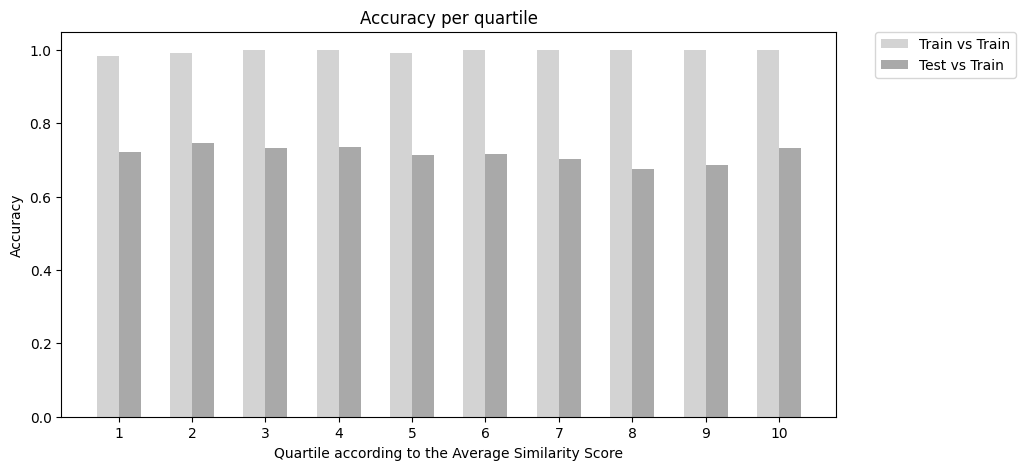

In [51]:
# plot the accuracy per quartile for the trainin (light grey) and test set (dark grey)
plt.figure(figsize=(10,5))
width=0.3
plt.bar(np.arange(n_quatriles), acc_train, width=width, color="lightgrey", label="Train vs Train")
plt.bar(np.arange(n_quatriles)+width, acc_test, width=width, color="darkgrey", label="Test vs Train")
plt.xticks(np.arange(n_quatriles)+width/2, np.arange(n_quatriles)+1)
plt.xlabel("Quartile according to the Average Similarity Score")
plt.ylabel("Accuracy")
plt.title("Accuracy per quartile")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

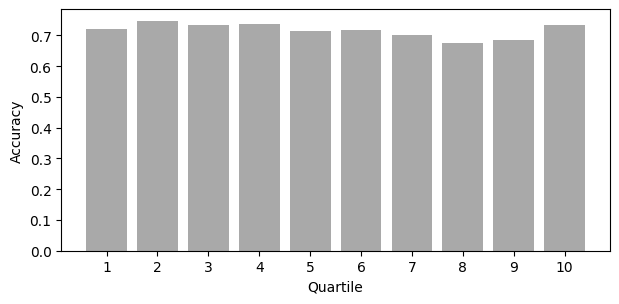

In [64]:
# plot the accuracy per quartile for the trainin (light grey) and test set (dark grey)
plt.figure(figsize=(16/2.54,8/2.54))
width=0.8
plt.bar(np.arange(n_quatriles), acc_test, width=width, color="darkgrey", label="Test")
plt.xticks(np.arange(n_quatriles), np.arange(n_quatriles)+1)
plt.xlabel("Quartile")
plt.ylabel("Accuracy")
#plt.title("Accuracy per quartile in the test set")
plt.tight_layout()
plt.savefig("figures/test_quartile_accuracy.png", dpi=300, bbox_inches='tight')

### Plot Scores (Useless in this case)

In [52]:
all_scores = train_scores + test_scores

index_train = ["Train vs Train"] * len(train_scores)
index_test  = ["Test vs Train"]  * len(test_scores)
all_index   = index_train + index_test

df = pd.DataFrame()
df["data"] = all_scores
df["index"] = all_index

threshold = np.min(all_scores)
print ("Setting similarity threshold to %.3f" %threshold)

Setting similarity threshold to 0.032


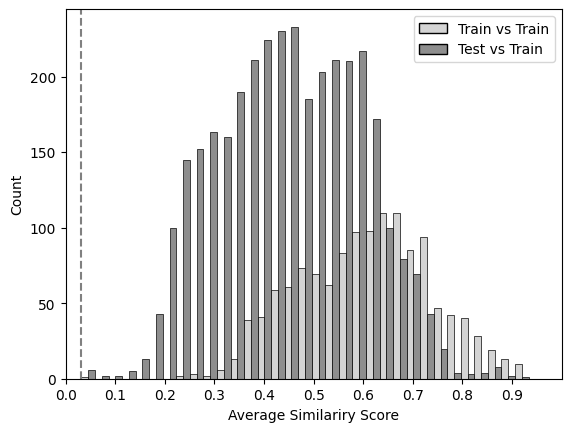

In [53]:
g = sns.histplot(data = df, x = "data", hue = "index", palette="Greys", multiple="dodge", shrink=1, stat = 'count')
g.legend_.set_title(None)
plt.axvline(threshold, 0, 60 , color='grey', linestyle = '--')
plt.xlabel("Average Similariry Score")
plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))
plt.savefig(data_path + "AD_Train_vs_Test.png", dpi=300)
plt.show()